In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [3]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

In [4]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [5]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [6]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [7]:
len(ef)

61532

In [8]:
F = (ef['use_record'] == 1)

In [9]:
ef = ef.loc[F]
len(ef)

9320

In [10]:
ef.ea_lv_systolic.value_counts()

 0.0    2297
-1.0     308
 3.0     220
 1.0     183
 2.0     147
-2.0      71
-3.0      30
Name: ea_lv_systolic, dtype: int64

## Calculate MDRD and add to feature table

In [11]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [12]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2524
1    2068
2    1439
4    1280
3    1258
5     503
dtype: int64

In [13]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4592
1    2697
2    1783
dtype: int64

In [14]:
sum(np.isnan(ef.mdrd))

248

In [15]:
sum(np.isnan(ef.bmi))

3242

In [16]:
sum(np.isnan(ef.fb_day1_balance_ml))

637

In [17]:
sum(np.isnan(ef.fb_day2_balance_ml))

2041

In [18]:
sum(np.isnan(ef.fb_day3_balance_ml))

3832

## Create general features table

In [19]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [20]:
## is apache score everr missing?
sum(np.isnan(ef.apsiii))

0

In [21]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

no_echo = np.isnan(ef.ea_key)
#X['no_echo'] = no_echo.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = ((np.isnan(lvsys) | (lvsys < -1)) & ~no_echo).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

tvpulm = ef.ea_tv_pulm_htn
tv_missing = ((np.isnan(tvpulm) | (tvpulm < -2)) & ~no_echo).astype(float)
tv_normal = (tvpulm == 0).astype(float)
tv_abnormal = ((tvpulm == -2) | (tvpulm > 0)).astype(float)
X['plm_htn_missing'] = tv_missing
X['plm_htn_normal'] = tv_normal
X['plm_htn_abnormal'] = tv_abnormal

rvcavity = ef.ea_rv_cavity
rvcav_missing = ((np.isnan(rvcavity) | (rvcavity < -2)) & ~no_echo).astype(float)
rvcav_normal = (rvcavity == 0).astype(float)
rvcav_small = (rvcavity == -1).astype(float)
rvcav_dilated = ((rvcavity == -2) | (rvcavity > 0)).astype(float)
X['rvcav_missing'] = rvcav_missing
X['rvcav_normal'] = rvcav_normal
X['rvcav_small'] = rvcav_small
X['rvcav_dilated'] = rvcav_dilated

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## which ICU was treating the patient
sicu = ef.st_sicu.astype(float)
sicu[np.isnan(sicu)] = 0
nsicu = ef.st_nsicu.astype(float)
nsicu[np.isnan(nsicu)] = 0
micu = ef.st_micu.astype(float)
micu[np.isnan(micu)] = 0
X['sicu'] = sicu
X['nsicu'] = nsicu
X['micu'] = micu

X.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,plm_htn_abnormal,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated,lactate,lactate_missing,sicu,nsicu,micu
1,0.100055,0.0,0.0,-0.002727,0.0,1.0,0.0,0.436365,0.0,-0.204515,...,1.0,0.0,1.0,0.0,0.0,0.716411,0.0,0.0,1.0,0.0
16,0.450966,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.364843,...,0.0,0.0,0.0,0.0,0.0,3.776100,0.0,0.0,0.0,1.0
20,0.164522,0.0,0.0,0.044261,0.0,0.0,0.0,0.404471,0.0,0.145859,...,0.0,0.0,1.0,0.0,0.0,0.065522,0.0,0.0,0.0,1.0
22,0.305922,0.0,0.0,-0.088287,0.0,0.0,0.0,0.729504,0.0,-1.036653,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0
25,0.390890,0.0,0.0,0.000000,1.0,0.0,0.0,-0.400352,0.0,2.204305,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,1.0


## With fluid balance

In [22]:
## make the features table. include fluid balance on days 1,2,3 of ICU stay
X_mortality = X.copy()

fluid_day1 = ef.fb_day1_balance_ml.values
fl_missing = np.isnan(fluid_day1) | ef.fb_day1_balance_truncated.eq(1).values # also filter insane fluid balances
fluid_day1[~fl_missing] = normalize(fluid_day1[~fl_missing])
fluid_day1[fl_missing] = 0
X_mortality['fluid_day1'] = fluid_day1
X_mortality['fluid_day1_missing'] = fl_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
fl_missing = np.isnan(fluid_day2) | ef.fb_day2_balance_truncated.eq(1).values
fluid_day2[~fl_missing] = normalize(fluid_day2[~fl_missing])
fluid_day2[fl_missing] = 0
X_mortality['fluid_day2'] = fluid_day2
X_mortality['fluid_day2_missing'] = fl_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
fl_missing = np.isnan(fluid_day3) | ef.fb_day3_balance_truncated.eq(1).values
fluid_day3[~fl_missing] = normalize(fluid_day3[~fl_missing])
fluid_day3[fl_missing] = 0
X_mortality['fluid_day3'] = fluid_day3
X_mortality['fluid_day3_missing'] = fl_missing.astype(float)

y_mortality = (ef.dod - ef.intime) < np.timedelta64(30, 'D')
y_mortality = y_mortality.astype(float)
X_mortality['mortality_day30'] = y_mortality

Xf = X_mortality.drop('mortality_day30', axis = 1)
yf = X_mortality['mortality_day30']

In [23]:
Xf.shape

(9320, 34)

In [24]:
yf.mean(), yf.sum(), len(yf)

(0.2811158798283262, 2620.0, 9320)

## Split into trainining and testing set

In [37]:
import sklearn as sk
import sklearn.model_selection

In [38]:
Xtr, Xte, ytr, yte = sk.model_selection.train_test_split(Xf, yf)
Xtr.shape

(6990, 34)

## Helper model building functions

In [39]:
def ridge(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    # observation error
    sigma = pm.HalfCauchy('sigma', 5)
    
    yh = T.dot(X, beta) + intercept
    ydist = pm.Normal('y', mu=yh, sd=sigma, observed=y)

In [40]:
def logistic(X, y, l=1.0):
    n = X.shape[1]
    beta = pm.Normal('beta', 0, l, shape=n)
    intercept = pm.Flat('intercept')
    
    yh = T.nnet.sigmoid(T.dot(X, beta) + intercept)
    ydist = pm.Bernoulli('y', yh, observed=y)

## Simple linear model for predicting 30-day mortality

In [41]:
with pm.Model() as model: 
    logistic(Xtr, ytr)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 3412.334981
         Iterations: 44
         Function evaluations: 55
         Gradient evaluations: 55


100%|██████████| 2000/2000 [10:00<00:00, 10.20it/s]


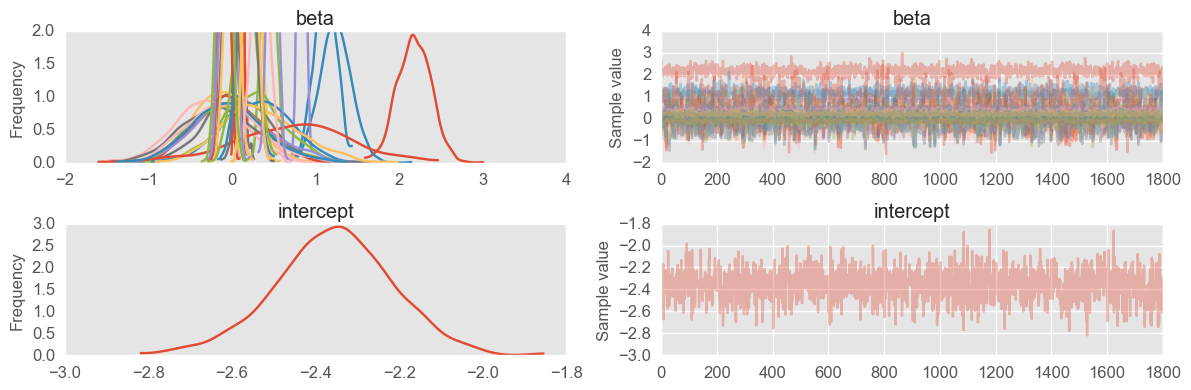

In [42]:
_ = pm.traceplot(trace[200:])

In [43]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=X_mortality.drop('mortality_day30', axis=1).columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,sicu,nsicu,micu,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
0,2.022356,0.911187,-0.159279,-0.028048,0.220127,0.421988,-0.007046,0.006033,1.537059,0.798824,...,-0.054443,0.181077,0.301470,-0.082600,0.295350,-0.022225,0.069527,0.123880,0.032715,-2.269661
1,2.597101,1.329257,-0.170134,0.171006,0.196305,0.538341,0.045928,0.057004,0.881603,0.916928,...,-0.066437,0.226331,0.329327,-0.058850,0.085425,-0.123927,0.374098,0.246793,-0.140814,-2.500112
2,2.679352,1.282553,-0.018225,0.106817,0.247230,0.458525,-0.031090,0.028819,1.423045,0.866943,...,0.015479,-0.024290,0.402473,-0.137603,0.142322,-0.100531,0.185922,0.267243,-0.259791,-2.466136
3,1.908499,1.026298,-0.167047,0.088635,0.268833,0.425174,0.032114,0.123104,0.802546,0.806303,...,-0.014751,0.405852,0.360623,-0.044817,0.177680,-0.031411,0.274194,0.160317,-0.055834,-2.419969
4,1.908499,1.026298,-0.167047,0.088635,0.268833,0.425174,0.032114,0.123104,0.802546,0.806303,...,-0.014751,0.405852,0.360623,-0.044817,0.177680,-0.031411,0.274194,0.160317,-0.055834,-2.419969


In [44]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,sicu,nsicu,micu,fluid_day1,fluid_day1_missing,fluid_day2,fluid_day2_missing,fluid_day3,fluid_day3_missing,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,...,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.180059,1.113508,-0.095789,0.081959,0.261275,0.439793,-0.011274,0.091776,1.240403,0.833851,...,-0.007271,0.163176,0.339344,-0.089465,0.173317,-0.055163,0.178221,0.224940,-0.094873,-2.359020
std,0.200185,0.127068,0.057460,0.040492,0.074527,0.069178,0.071065,0.030928,0.186916,0.039556,...,0.071550,0.131274,0.095300,0.048362,0.104113,0.074104,0.091285,0.067712,0.077156,0.140761
min,1.589730,0.696960,-0.265813,-0.035691,-0.012608,0.240344,-0.265362,-0.008561,0.674219,0.693997,...,-0.290732,-0.286358,0.027904,-0.282803,-0.165546,-0.312487,-0.133417,0.004752,-0.363162,-2.818373
25%,2.044032,1.030116,-0.134082,0.056785,0.212918,0.392837,-0.059063,0.071520,1.113576,0.807399,...,-0.057408,0.077703,0.273554,-0.120245,0.102179,-0.103636,0.116567,0.180862,-0.150051,-2.447018
50%,2.178861,1.117635,-0.095730,0.078211,0.261467,0.441080,-0.013549,0.091415,1.238326,0.833216,...,-0.009167,0.163837,0.338567,-0.090185,0.171517,-0.054866,0.174679,0.225663,-0.095770,-2.355626
75%,2.316890,1.199135,-0.057153,0.105360,0.308652,0.484800,0.035706,0.113410,1.364761,0.860905,...,0.039466,0.248824,0.404389,-0.058403,0.242287,-0.007176,0.242683,0.268215,-0.041327,-2.267095
max,3.003094,1.434723,0.095323,0.263258,0.569075,0.648695,0.250496,0.180462,2.144403,0.964757,...,0.247698,0.530991,0.702195,0.088050,0.501425,0.212406,0.498792,0.459818,0.191708,-1.854862


(0.77453536798601186, 0.75962041010968051)

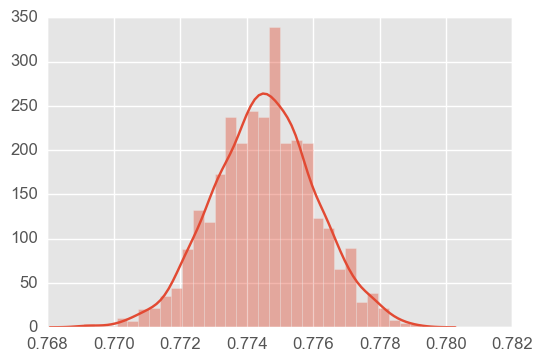

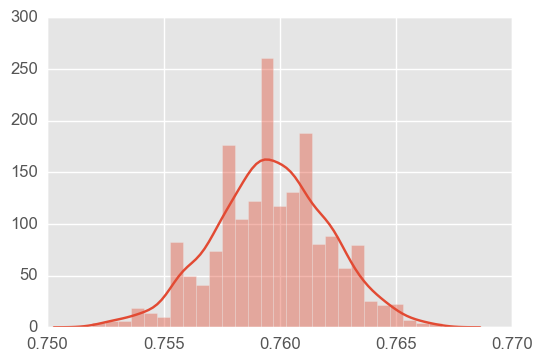

In [46]:
W = sample_coefs.values[:,:Xtr.shape[1]]
b = sample_coefs['intercept'].values

ypr = np.dot(Xtr, W.T) + b
acc_tr = np.mean((ypr.T > 0) == ytr[np.newaxis, :], axis = 1)
acc_tr_ = acc_tr.mean()

ypr = np.dot(Xte, W.T) + b
acc_te = np.mean((ypr.T > 0) == yte[np.newaxis, :], axis = 1)
acc_te_ = acc_te.mean()

plt.figure()
sns.distplot(acc_tr)

plt.figure()
sns.distplot(acc_te)

acc_tr_, acc_te_

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,1.995287,1.060809,-0.090946,0.048011,0.231229
std,0.200418,0.128401,0.062272,0.032422,0.071409
min,1.366780,0.571160,-0.291304,-0.088262,-0.031662
25%,1.856048,0.976927,-0.132207,0.027783,0.184540
50%,1.994567,1.057752,-0.093388,0.049130,0.232140
75%,2.122951,1.146773,-0.048350,0.069231,0.280320
max,2.667465,1.446783,0.115635,0.181276,0.472953


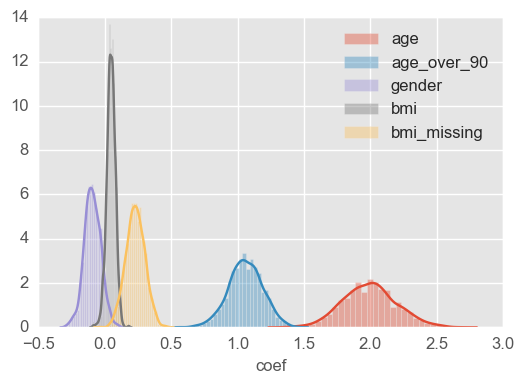

In [95]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.486592,-0.019165,0.841221,0.104546,1.311497,0.472818,0.034097
std,0.065815,0.071129,0.039912,0.031225,0.188419,0.053450,0.068336
min,0.245703,-0.237979,0.704664,-0.006876,0.791967,0.313570,-0.200013
25%,0.441564,-0.068613,0.814063,0.083915,1.178023,0.434887,-0.010266
50%,0.486454,-0.016570,0.841609,0.105160,1.313454,0.472195,0.034158
75%,0.531441,0.030131,0.867966,0.125190,1.436763,0.507613,0.079670
max,0.684177,0.197281,0.974174,0.219546,1.936071,0.639516,0.288398


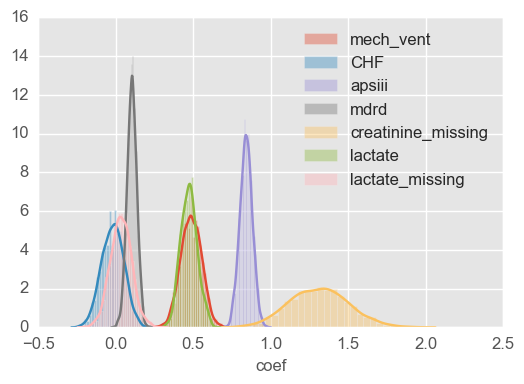

In [96]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,micu,sicu,nsicu
count,1800.000000,1800.000000,1800.000000
mean,0.263650,-0.006148,0.077406
std,0.098765,0.076475,0.138020
min,-0.033434,-0.289963,-0.361893
25%,0.196646,-0.057975,-0.016091
50%,0.261853,-0.005348,0.083682
75%,0.330567,0.046496,0.175849
max,0.579608,0.247389,0.536225


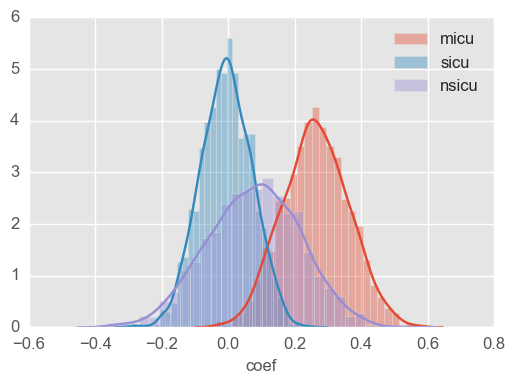

In [97]:
coefs = ['micu', 'sicu', 'nsicu']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.199058,-0.048165,0.361448,-0.278760,-0.186235,0.336696
std,0.379867,0.373130,0.388624,0.406205,0.415480,0.390238
min,-0.978194,-1.135083,-1.019290,-1.420401,-1.465567,-0.950254
25%,-0.061047,-0.306827,0.092363,-0.574273,-0.471971,0.080936
50%,0.194894,-0.058674,0.341152,-0.273692,-0.193345,0.324364
75%,0.454475,0.203934,0.622803,-0.018599,0.097034,0.597341
max,1.518933,1.299524,1.770554,1.387983,1.258768,1.687186


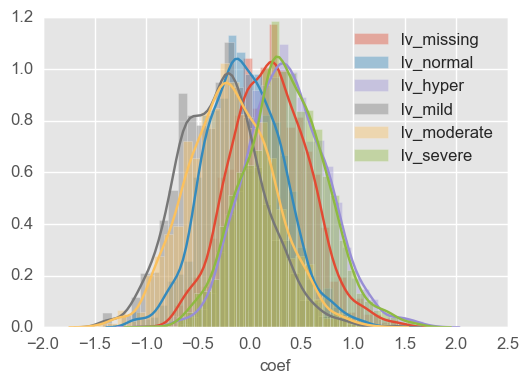

In [98]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.024276,-0.191362,0.746975,-0.101672
std,0.438950,0.429835,0.698438,0.434004
min,-1.545643,-1.566189,-1.320381,-1.480833
25%,-0.329064,-0.501127,0.263732,-0.403578
50%,-0.057739,-0.207800,0.725574,-0.117900
75%,0.315474,0.117059,1.237222,0.224825
max,1.258967,1.120764,3.090533,1.099742


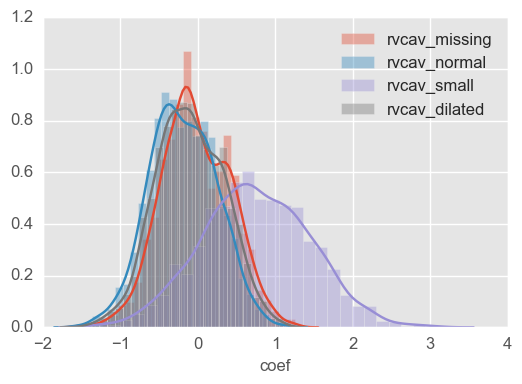

In [99]:
coefs = ['rvcav_missing', 'rvcav_normal', 'rvcav_small', 'rvcav_dilated']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,plm_htn_missing,plm_htn_normal,plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,-0.025505,-0.064439,0.441661
std,0.437799,0.444667,0.439024
min,-1.417602,-1.381862,-0.941099
25%,-0.331402,-0.379275,0.134550
50%,-0.026846,-0.078150,0.442779
75%,0.274899,0.224692,0.743966
max,1.439608,1.534751,1.941800


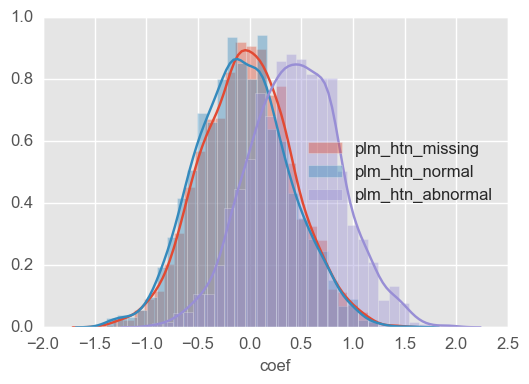

In [100]:
coefs = ['plm_htn_missing', 'plm_htn_normal', 'plm_htn_abnormal']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1,fluid_day2,fluid_day3
count,1800.000000,1800.000000,1800.000000
mean,-0.065188,0.010932,0.144176
std,0.050004,0.067659,0.053413
min,-0.219992,-0.235883,-0.034185
25%,-0.099895,-0.033469,0.109144
50%,-0.065531,0.011944,0.145187
75%,-0.033771,0.056708,0.182288
max,0.111976,0.263165,0.363255


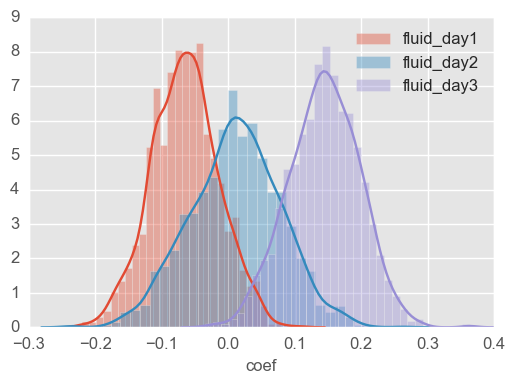

In [101]:
coefs = ['fluid_day1', 'fluid_day2', 'fluid_day3']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1_missing,fluid_day2_missing,fluid_day3_missing
count,1800.000000,1800.000000,1800.000000
mean,-0.350345,0.410102,-0.395135
std,0.180013,0.420027,0.597717
min,-0.917844,-1.081255,-2.642465
25%,-0.474834,0.133610,-0.792234
50%,-0.348360,0.423849,-0.353050
75%,-0.229265,0.680752,-0.001058
max,0.204824,1.719124,1.423001


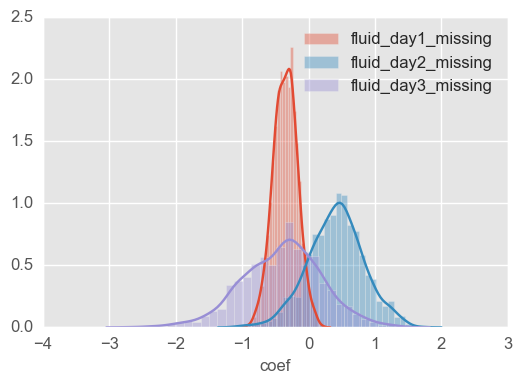

In [102]:
coefs = ['fluid_day1_missing', 'fluid_day2_missing', 'fluid_day3_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

## Add interaction terms of interest

In [25]:
X_int = Xf.copy()

fluid_terms = [c for c in X_int.columns if 'fluid' in c]
echo_terms = [c for c in X_int.columns if ('lv_' in c) or ('plm_' in c) or ('rvcav_' in c)]
for fluid_term in fluid_terms: 
    X_int['{}:{}'.format(fluid_term, 'CHF')] = X_int[fluid_term] * X_int['CHF']
    X_int['{}:{}'.format(fluid_term, 'mech_vent')] = X_int[fluid_term] * X_int['mech_vent']
    
    for echo_term in echo_terms: 
        X_int['{}:{}'.format(fluid_term, echo_term)] = X_int[fluid_term] * X_int[echo_term]

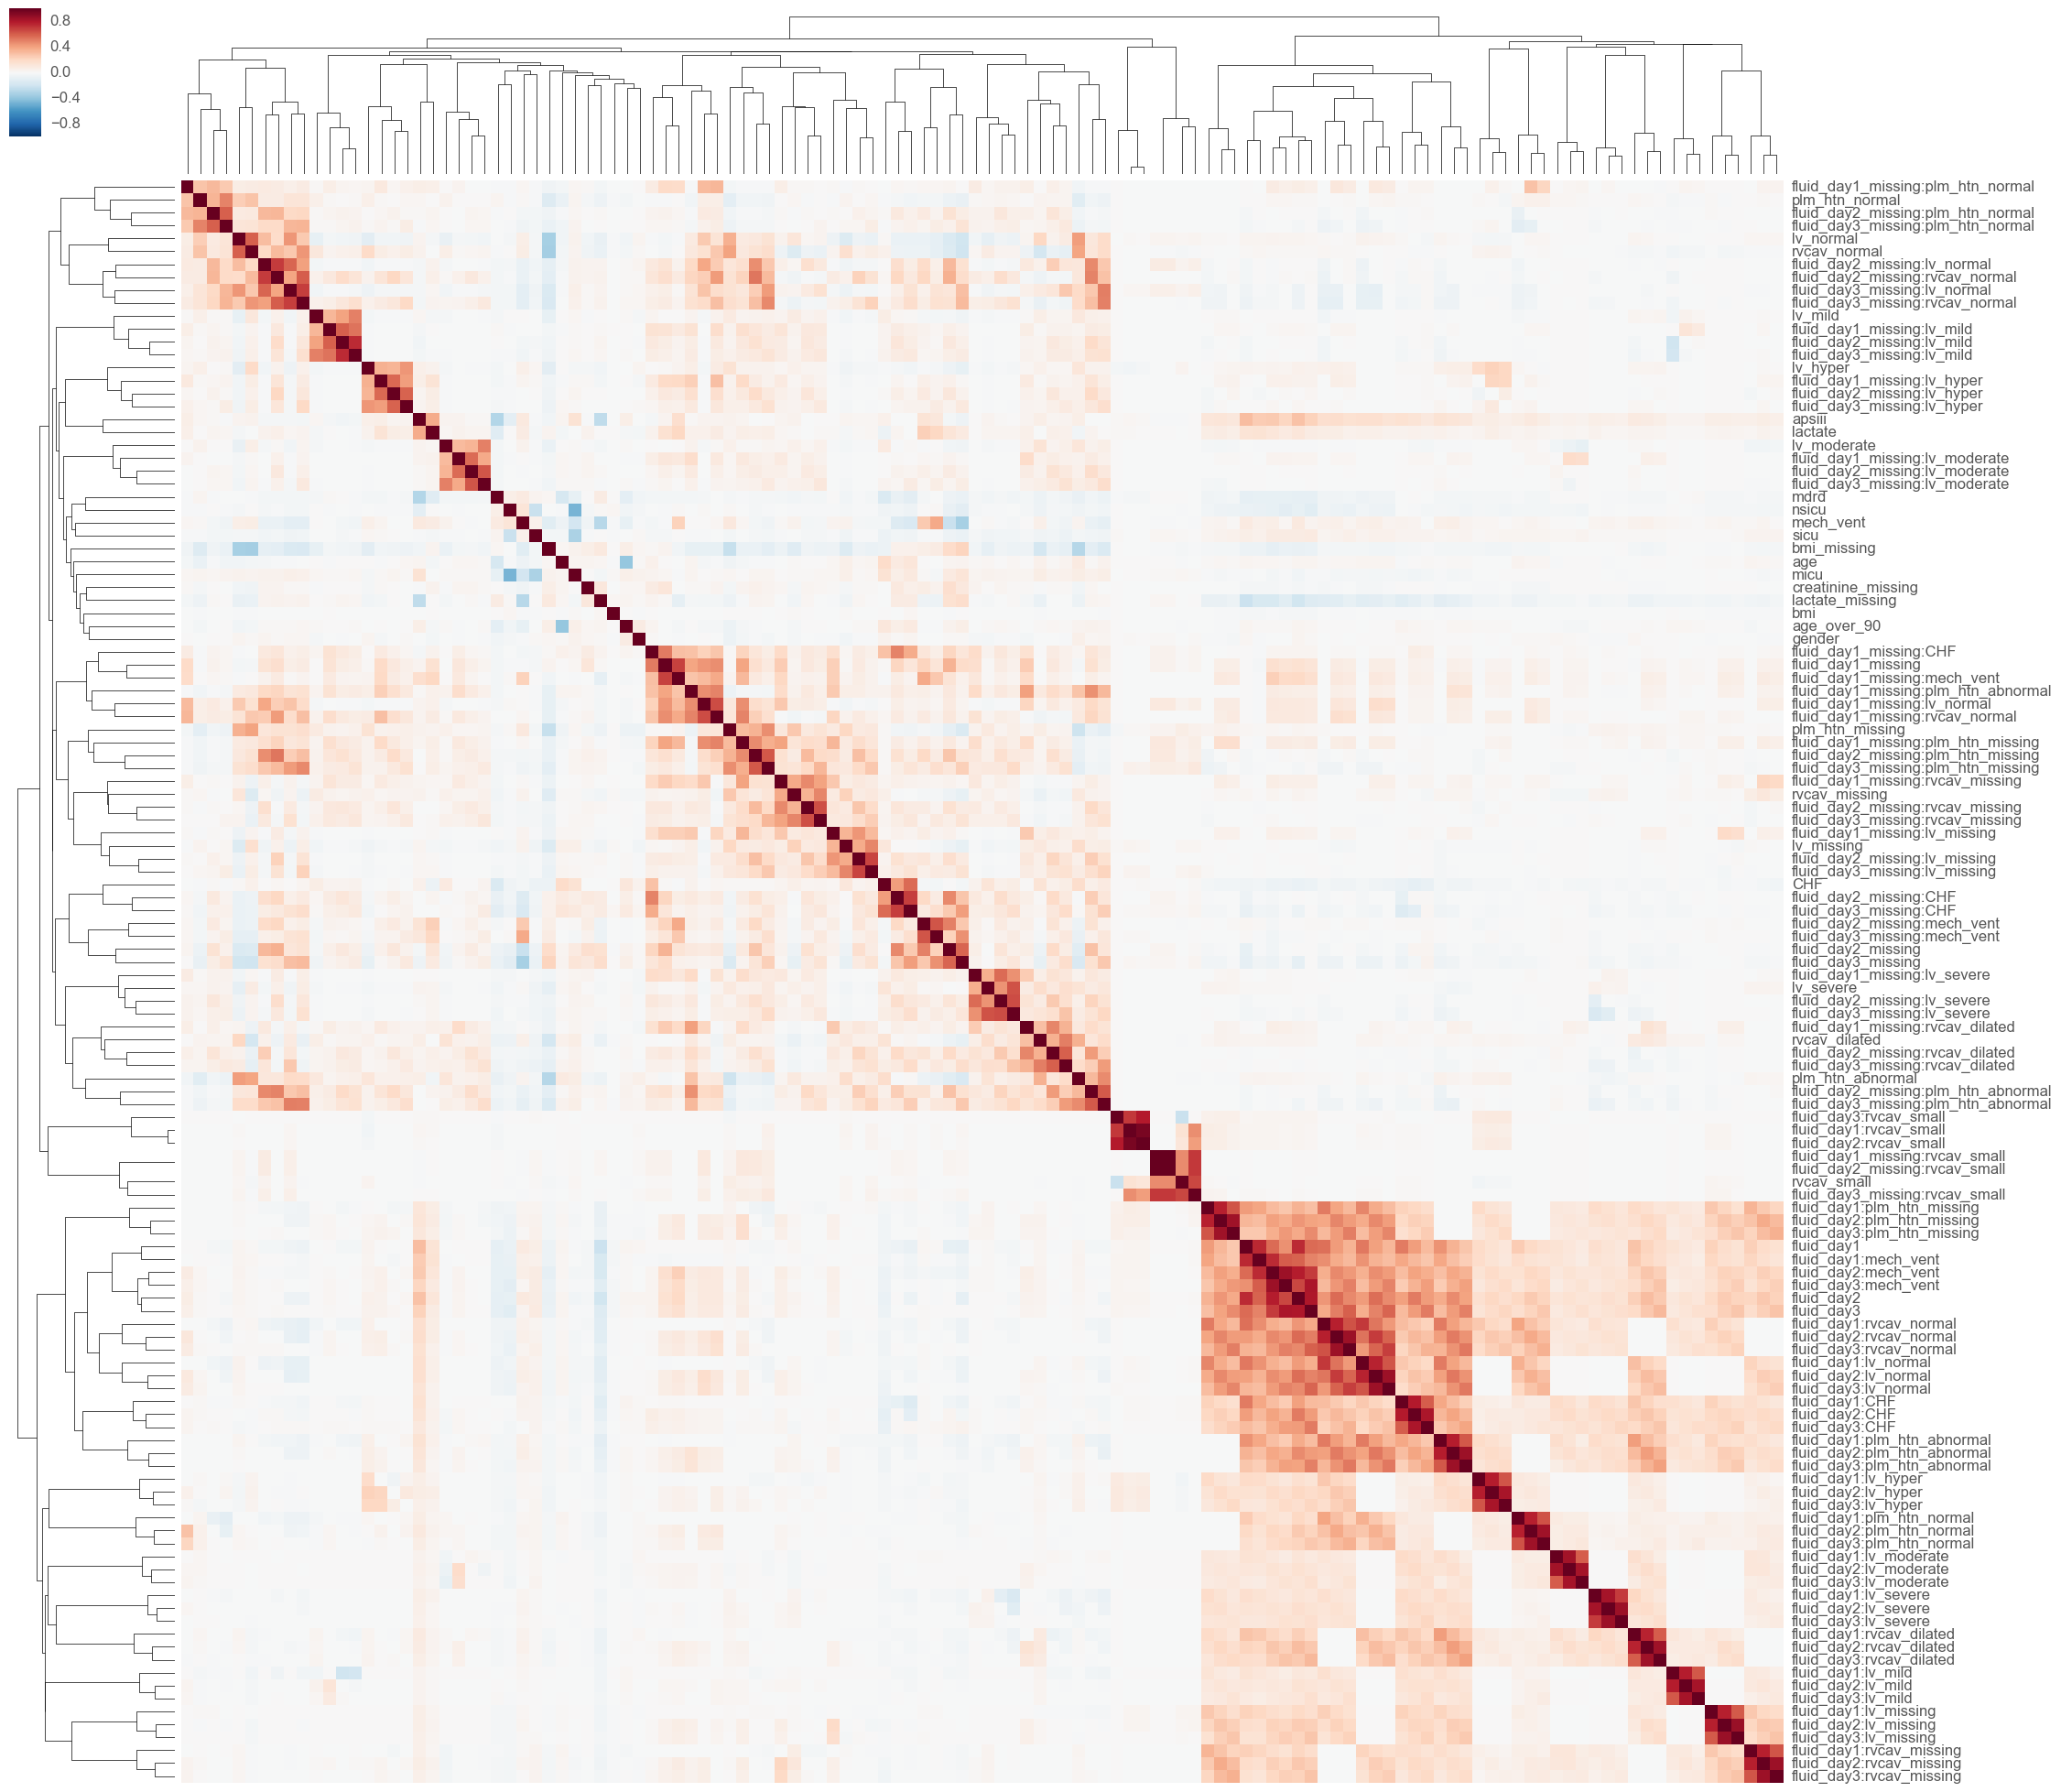

In [36]:
to_plot = X_int.corr()
g = sns.clustermap(to_plot, xticklabels = False, figsize = (25, 25))
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0)

In [111]:
Xtr, Xte, ytr, yte = sk.model_selection.train_test_split(X_int, yf)

In [112]:
Xtr.shape

(6990, 124)

In [113]:
with pm.Model() as model: 
    logistic(Xtr, ytr)
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    trace = pm.sample(2000, step)

Optimization terminated successfully.
         Current function value: 3473.251118
         Iterations: 84
         Function evaluations: 104
         Gradient evaluations: 104


100%|██████████| 2000/2000 [2:04:33<00:00,  1.27s/it]


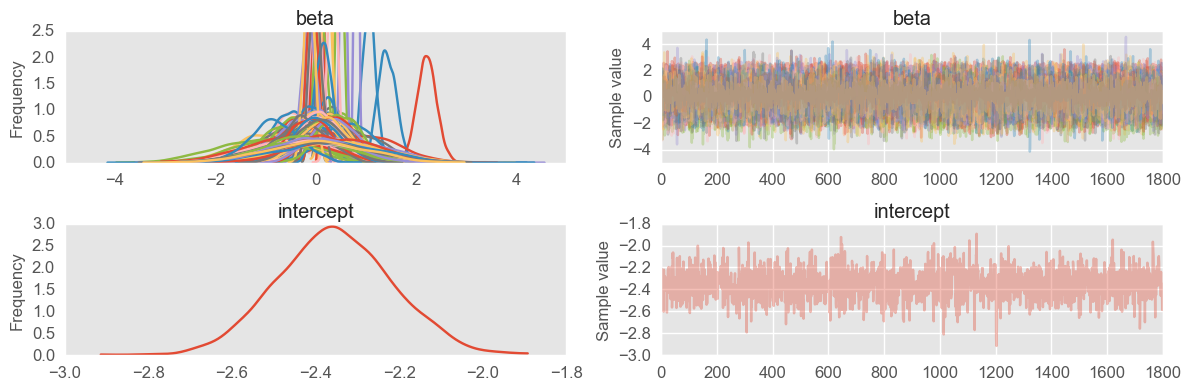

In [114]:
_ = pm.traceplot(trace[200:])

In [116]:
sample_coefs = pd.DataFrame(trace[200:]['beta'], columns=Xtr.columns)
sample_coefs['intercept'] = trace[200:]['intercept']
sample_coefs.head()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,fluid_day3_missing:lv_moderate,fluid_day3_missing:lv_severe,fluid_day3_missing:plm_htn_missing,fluid_day3_missing:plm_htn_normal,fluid_day3_missing:plm_htn_abnormal,fluid_day3_missing:rvcav_missing,fluid_day3_missing:rvcav_normal,fluid_day3_missing:rvcav_small,fluid_day3_missing:rvcav_dilated,intercept
0,2.495709,1.217569,-0.196311,0.030314,0.239826,0.441007,-0.026072,0.116239,1.424278,0.852211,...,-0.178936,-0.008129,0.714834,-0.382153,-0.594792,-0.848060,-0.687599,0.627585,-0.719720,-2.210311
1,2.495709,1.217569,-0.196311,0.030314,0.239826,0.441007,-0.026072,0.116239,1.424278,0.852211,...,-0.178936,-0.008129,0.714834,-0.382153,-0.594792,-0.848060,-0.687599,0.627585,-0.719720,-2.210311
2,2.233121,1.136736,-0.164286,0.069002,0.155119,0.400240,0.182147,0.146587,1.471060,0.889525,...,-0.523438,0.387707,-0.539692,0.651836,-0.757744,1.965103,0.473936,0.101931,1.466867,-2.320736
3,2.218711,1.109101,0.032686,0.047547,0.467884,0.441192,0.075204,0.206120,1.331866,0.894247,...,0.009380,1.524848,-0.765302,0.250626,1.581521,1.480581,-0.286795,0.393367,-2.468158,-2.465321
4,2.175500,1.065039,-0.070735,0.068675,0.386929,0.596682,0.067960,0.119103,1.421742,0.783837,...,-1.706056,1.918136,-1.216790,1.027209,1.139483,0.086058,-0.131640,0.220710,-1.941024,-2.535486


In [117]:
sample_coefs.describe()

,age,age_over_90,gender,bmi,bmi_missing,mech_vent,CHF,mdrd,creatinine_missing,apsiii,...,fluid_day3_missing:lv_moderate,fluid_day3_missing:lv_severe,fluid_day3_missing:plm_htn_missing,fluid_day3_missing:plm_htn_normal,fluid_day3_missing:plm_htn_abnormal,fluid_day3_missing:rvcav_missing,fluid_day3_missing:rvcav_normal,fluid_day3_missing:rvcav_small,fluid_day3_missing:rvcav_dilated,intercept
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,...,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.216985,1.062119,-0.113977,0.047509,0.250453,0.487388,0.070007,0.119028,1.421624,0.815494,...,-0.025017,0.402019,-0.178311,0.003783,0.450741,0.273651,-0.085832,-0.005858,0.012236,-2.354571
std,0.193535,0.130439,0.059738,0.032092,0.070363,0.067503,0.070759,0.032131,0.178628,0.040024,...,1.027905,0.982696,0.922318,0.949734,0.887682,1.016209,0.835705,1.016032,0.984758,0.139251
min,1.536440,0.663227,-0.303084,-0.065565,-0.002989,0.286236,-0.132253,0.007953,0.899438,0.654123,...,-3.334391,-3.145316,-2.878410,-3.197922,-2.623991,-4.149069,-2.549858,-3.524636,-3.431374,-2.913925
25%,2.090370,0.972495,-0.154099,0.026961,0.203621,0.442786,0.020121,0.098375,1.297488,0.787708,...,-0.710035,-0.274502,-0.820687,-0.641260,-0.147536,-0.348511,-0.635486,-0.673458,-0.643986,-2.446783
50%,2.215414,1.065927,-0.113290,0.047622,0.250544,0.490517,0.069715,0.120370,1.416578,0.815079,...,0.013774,0.411310,-0.159404,-0.019855,0.480411,0.270352,-0.081556,0.022451,0.034905,-2.355021
75%,2.345945,1.150288,-0.074531,0.069016,0.296277,0.530618,0.120774,0.140659,1.548986,0.843666,...,0.676945,1.054997,0.441415,0.649345,1.042754,0.966558,0.492113,0.688128,0.675041,-2.263308
max,2.843826,1.505305,0.055724,0.160193,0.501885,0.725618,0.296779,0.237552,1.921100,0.945266,...,3.414570,3.977485,2.821879,2.998940,3.618045,4.358935,2.520830,3.104730,2.969691,-1.892512


(0.77249928469241769, 0.76954887935145455)

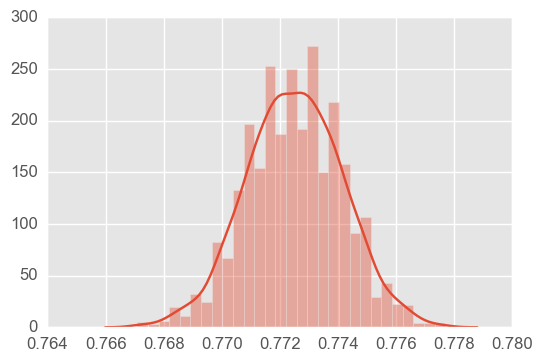

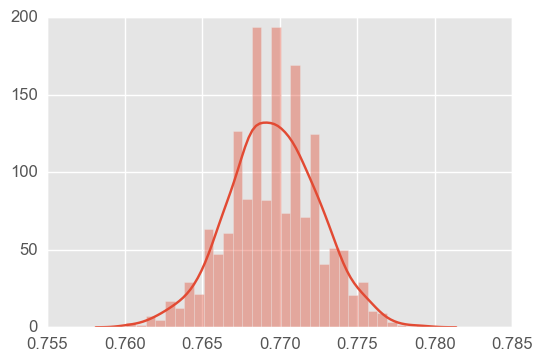

In [119]:
W = sample_coefs.values[:,:Xtr.shape[1]]
b = sample_coefs['intercept'].values

ypr = np.dot(Xtr, W.T) + b
acc_tr = np.mean((ypr.T > 0) == ytr[np.newaxis, :], axis = 1)
acc_tr_ = acc_tr.mean()

ypr = np.dot(Xte, W.T) + b
acc_te = np.mean((ypr.T > 0) == yte[np.newaxis, :], axis = 1)
acc_te_ = acc_te.mean()

plt.figure()
sns.distplot(acc_tr)

plt.figure()
sns.distplot(acc_te)

acc_tr_, acc_te_

,age,age_over_90,gender,bmi,bmi_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,2.216985,1.062119,-0.113977,0.047509,0.250453
std,0.193535,0.130439,0.059738,0.032092,0.070363
min,1.536440,0.663227,-0.303084,-0.065565,-0.002989
25%,2.090370,0.972495,-0.154099,0.026961,0.203621
50%,2.215414,1.065927,-0.113290,0.047622,0.250544
75%,2.345945,1.150288,-0.074531,0.069016,0.296277
max,2.843826,1.505305,0.055724,0.160193,0.501885


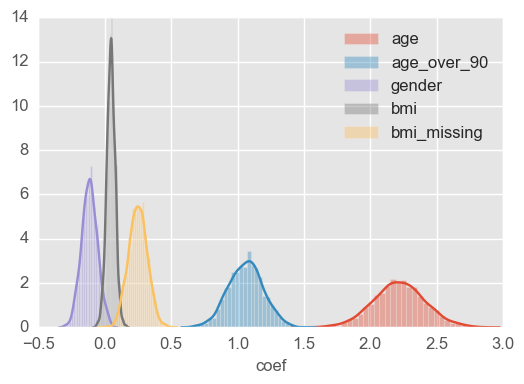

In [120]:
coefs = ['age', 'age_over_90', 'gender', 'bmi', 'bmi_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,mech_vent,CHF,apsiii,mdrd,creatinine_missing,lactate,lactate_missing
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.487388,0.070007,0.815494,0.119028,1.421624,0.553101,-0.028948
std,0.067503,0.070759,0.040024,0.032131,0.178628,0.053066,0.070505
min,0.286236,-0.132253,0.654123,0.007953,0.899438,0.380015,-0.274733
25%,0.442786,0.020121,0.787708,0.098375,1.297488,0.516511,-0.074123
50%,0.490517,0.069715,0.815079,0.120370,1.416578,0.553801,-0.031586
75%,0.530618,0.120774,0.843666,0.140659,1.548986,0.588657,0.017591
max,0.725618,0.296779,0.945266,0.237552,1.921100,0.724488,0.229880


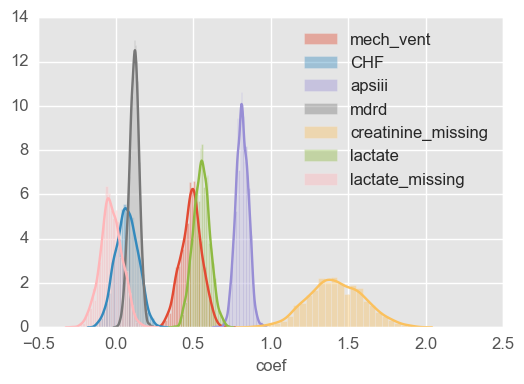

In [121]:
coefs = ['mech_vent', 'CHF', 'apsiii', 'mdrd', 'creatinine_missing', 'lactate', 'lactate_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,micu,sicu,nsicu
count,1800.000000,1800.000000,1800.000000
mean,0.340225,-0.023454,0.096797
std,0.093874,0.070544,0.129133
min,-0.057103,-0.216719,-0.277906
25%,0.277910,-0.073805,0.011078
50%,0.336026,-0.025311,0.094394
75%,0.403125,0.026634,0.184704
max,0.672758,0.280789,0.577053


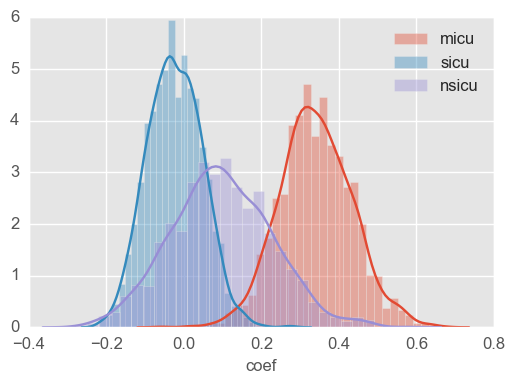

In [122]:
coefs = ['micu', 'sicu', 'nsicu']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,lv_missing,lv_normal,lv_hyper,lv_mild,lv_moderate,lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.287344,-0.016296,0.407266,-0.436053,-0.073258,0.143324
std,0.368001,0.354781,0.376765,0.399238,0.406158,0.385618
min,-0.930471,-1.225563,-0.926026,-1.598262,-1.315192,-1.093568
25%,0.037333,-0.266500,0.137636,-0.703666,-0.356656,-0.111716
50%,0.296051,-0.020657,0.410199,-0.442143,-0.057882,0.134967
75%,0.527944,0.247161,0.676195,-0.164826,0.201480,0.405643
max,1.452282,1.101180,1.633732,0.938485,1.127338,1.329953


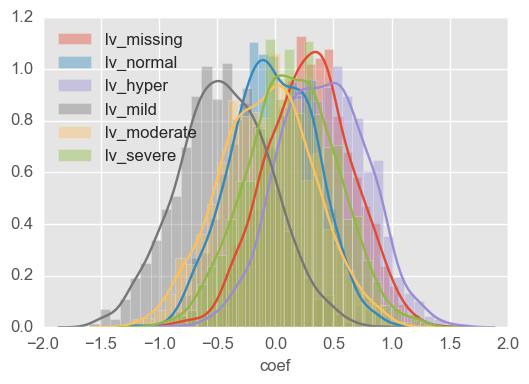

In [123]:
coefs = ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,rvcav_missing,rvcav_normal,rvcav_small,rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.185371,-0.192105,0.879764,-0.254045
std,0.441354,0.431867,0.770409,0.439105
min,-1.745617,-1.570734,-2.079202,-1.543130
25%,-0.494409,-0.482205,0.346207,-0.544578
50%,-0.177125,-0.189986,0.907514,-0.261892
75%,0.110527,0.122303,1.407950,0.046058
max,1.202086,1.131997,3.461471,1.170450


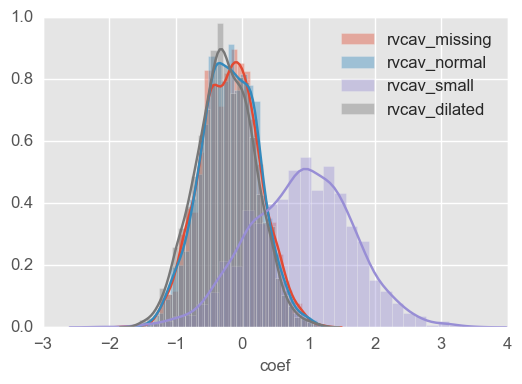

In [124]:
coefs = ['rvcav_missing', 'rvcav_normal', 'rvcav_small', 'rvcav_dilated']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,plm_htn_missing,plm_htn_normal,plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,0.067490,-0.086926,0.403263
std,0.454047,0.467437,0.449864
min,-1.383063,-1.450611,-1.019619
25%,-0.230761,-0.412110,0.097530
50%,0.060495,-0.100013,0.402301
75%,0.374534,0.236908,0.693940
max,1.781626,1.641973,2.059248


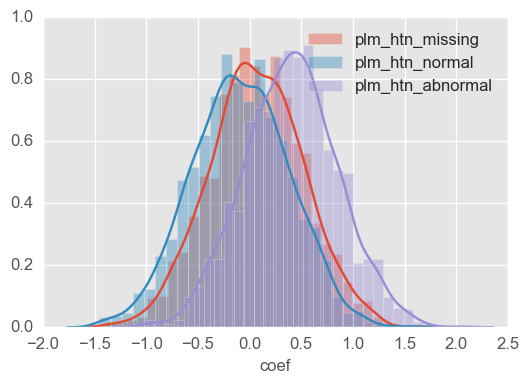

In [125]:
coefs = ['plm_htn_missing', 'plm_htn_normal', 'plm_htn_abnormal']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1,fluid_day2,fluid_day3
count,1800.000000,1800.000000,1800.000000
mean,0.020579,0.016924,0.223828
std,0.086385,0.117073,0.096333
min,-0.257002,-0.331615,-0.099327
25%,-0.036325,-0.064128,0.160112
50%,0.021653,0.015395,0.220944
75%,0.077665,0.093103,0.288174
max,0.308518,0.497543,0.550004


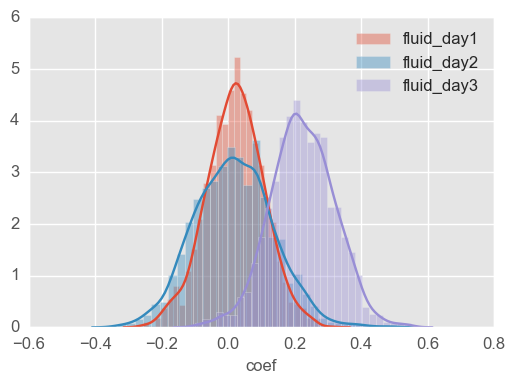

In [126]:
coefs = ['fluid_day1', 'fluid_day2', 'fluid_day3']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

,fluid_day1_missing,fluid_day2_missing,fluid_day3_missing
count,1800.000000,1800.000000,1800.000000
mean,0.202113,0.696183,0.304974
std,0.336034,0.649714,0.662667
min,-0.948493,-1.444995,-2.365852
25%,-0.016143,0.257363,-0.143164
50%,0.218955,0.680460,0.309992
75%,0.422219,1.144007,0.758187
max,1.313059,2.768393,2.221545


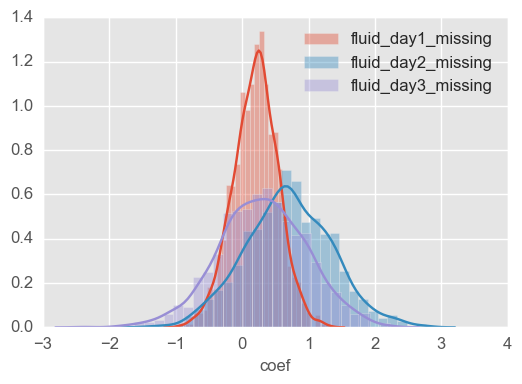

In [127]:
coefs = ['fluid_day1_missing', 'fluid_day2_missing', 'fluid_day3_missing']
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

Interaction terms with CHF

,fluid_day1:CHF,fluid_day1_missing:CHF,fluid_day2:CHF,fluid_day2_missing:CHF,fluid_day3:CHF,fluid_day3_missing:CHF
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.003289,-0.324474,0.154636,0.142884,-0.009620,-0.050074
std,0.115975,0.443664,0.166920,0.767711,0.123273,0.855119
min,-0.362938,-2.168700,-0.529662,-2.265109,-0.455774,-2.936873
25%,-0.075953,-0.620389,0.038180,-0.402476,-0.091127,-0.653978
50%,0.006319,-0.324298,0.155097,0.145581,-0.016175,-0.059239
75%,0.080149,-0.016893,0.271085,0.658024,0.072854,0.523351
max,0.394269,1.197836,0.723767,2.568067,0.380367,2.658303


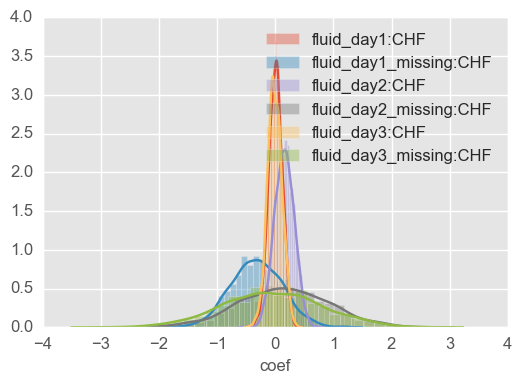

In [134]:
coefs = [c for c in sample_coefs.columns if ':CHF' in c]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

Interaction terms with mechanical ventilation

,fluid_day1:mech_vent,fluid_day1_missing:mech_vent,fluid_day2:mech_vent,fluid_day2_missing:mech_vent,fluid_day3:mech_vent,fluid_day3_missing:mech_vent
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.062641,-0.096485,-0.130148,-0.244137,-0.127129,-0.219310
std,0.102294,0.367317,0.139522,0.697718,0.109851,0.806239
min,-0.357715,-1.538317,-0.629611,-2.296867,-0.536505,-3.368411
25%,-0.133015,-0.334448,-0.221946,-0.709763,-0.201235,-0.744984
50%,-0.064595,-0.096131,-0.132835,-0.244512,-0.129050,-0.246864
75%,0.003228,0.148603,-0.032912,0.227633,-0.053940,0.305798
max,0.268827,1.136497,0.309392,1.722915,0.252274,2.613496


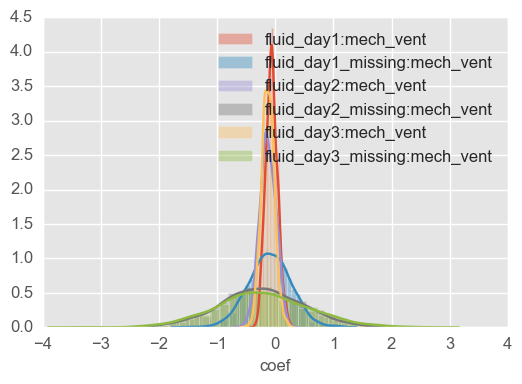

In [135]:
coefs = [c for c in sample_coefs.columns if ':mech_vent' in c]
display(sample_coefs[coefs].describe())
for coef in coefs:
    sns.distplot(sample_coefs[coef], label=coef)
plt.xlabel('coef')
_ = plt.legend(loc='best')

Interaction terms with echo variables

,fluid_day1:lv_missing,fluid_day1:lv_normal,fluid_day1:lv_hyper,fluid_day1:lv_mild,fluid_day1:lv_moderate,fluid_day1:lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.463069,0.003886,0.320915,0.044581,0.016710,-0.040593
std,0.412939,0.384053,0.430716,0.494677,0.487463,0.448422
min,-1.784776,-1.238051,-1.017509,-1.921067,-1.620579,-1.436552
25%,-0.745026,-0.261581,0.024484,-0.302379,-0.314175,-0.341055
50%,-0.471533,-0.002682,0.307662,0.046637,-0.004190,-0.055201
75%,-0.203071,0.246879,0.606724,0.376280,0.341203,0.258170
max,0.980627,1.443558,1.572144,1.658269,1.597146,1.320332


,fluid_day1_missing:lv_missing,fluid_day1_missing:lv_normal,fluid_day1_missing:lv_hyper,fluid_day1_missing:lv_mild,fluid_day1_missing:lv_moderate,fluid_day1_missing:lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.360526,0.183236,-0.890336,0.232191,0.034633,0.042388
std,0.647676,0.547057,0.717027,0.886424,0.842878,0.819817
min,-2.375659,-1.562369,-3.553798,-3.172741,-3.046333,-2.564726
25%,-0.803780,-0.172095,-1.365523,-0.349713,-0.526634,-0.497528
50%,-0.375135,0.186028,-0.874719,0.244987,0.035503,0.036664
75%,0.061447,0.549054,-0.392396,0.789441,0.596723,0.598843
max,2.411104,1.847460,2.162650,3.185711,3.180875,2.628994


,fluid_day2:lv_missing,fluid_day2:lv_normal,fluid_day2:lv_hyper,fluid_day2:lv_mild,fluid_day2:lv_moderate,fluid_day2:lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.153564,-0.038686,-0.398025,0.143991,-0.310360,0.638475
std,0.451759,0.410967,0.483296,0.552146,0.554426,0.514286
min,-1.708356,-1.564374,-2.253350,-1.750360,-2.021315,-1.115540
25%,-0.450847,-0.299557,-0.700532,-0.249381,-0.683514,0.292930
50%,-0.154217,-0.032742,-0.404140,0.163585,-0.302885,0.648333
75%,0.162559,0.242408,-0.094288,0.511958,0.065726,0.992332
max,1.360326,1.337203,1.259317,2.087176,1.400970,2.608587


,fluid_day2_missing:lv_missing,fluid_day2_missing:lv_normal,fluid_day2_missing:lv_hyper,fluid_day2_missing:lv_mild,fluid_day2_missing:lv_moderate,fluid_day2_missing:lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.017845,-1.139173,-0.041830,-0.016924,0.429146,0.114072
std,0.946124,0.864688,0.900670,0.942051,0.917205,0.939919
min,-2.959270,-3.974495,-3.296557,-3.206966,-2.487513,-2.735934
25%,-0.628405,-1.741270,-0.659675,-0.633544,-0.221857,-0.510974
50%,0.030829,-1.110118,-0.035871,-0.021295,0.448769,0.109043
75%,0.651768,-0.539430,0.549532,0.619702,1.032985,0.754893
max,3.283758,1.343061,2.996275,3.514242,3.496950,3.242167


,fluid_day3:lv_missing,fluid_day3:lv_normal,fluid_day3:lv_hyper,fluid_day3:lv_mild,fluid_day3:lv_moderate,fluid_day3:lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.486899,0.060253,0.346450,-0.813798,0.373347,-0.258692
std,0.408276,0.383316,0.433116,0.486819,0.463155,0.472782
min,-0.692976,-1.142219,-1.132147,-2.208181,-1.176553,-1.604530
25%,0.192847,-0.206901,0.052902,-1.128657,0.052480,-0.570875
50%,0.474312,0.055078,0.349020,-0.823997,0.372436,-0.267533
75%,0.768991,0.335625,0.640767,-0.486407,0.693316,0.057212
max,1.780703,1.202385,1.724715,0.909824,2.080174,1.248324


,fluid_day3_missing:lv_missing,fluid_day3_missing:lv_normal,fluid_day3_missing:lv_hyper,fluid_day3_missing:lv_mild,fluid_day3_missing:lv_moderate,fluid_day3_missing:lv_severe
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.140540,-0.020154,0.038187,-0.039925,-0.025017,0.402019
std,0.983481,0.790461,1.039939,1.028169,1.027905,0.982696
min,-3.580270,-2.847606,-3.309618,-3.601550,-3.334391,-3.145316
25%,-0.802783,-0.556311,-0.659966,-0.761387,-0.710035,-0.274502
50%,-0.156869,0.021568,0.008600,-0.045636,0.013774,0.411310
75%,0.550132,0.513482,0.724852,0.669922,0.676945,1.054997
max,3.003563,2.169962,4.208099,3.727355,3.414570,3.977485


,fluid_day1:rvcav_missing,fluid_day1:rvcav_normal,fluid_day1:rvcav_small,fluid_day1:rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.093207,-0.325779,-0.014614,0.149224
std,0.482404,0.452982,0.844674,0.462246
min,-1.643012,-1.937823,-2.623756,-1.678399
25%,-0.213384,-0.631526,-0.556989,-0.149400
50%,0.093532,-0.344280,-0.039168,0.142493
75%,0.413718,-0.010344,0.533558,0.474226
max,1.850300,1.149384,2.926852,1.617553


,fluid_day1_missing:rvcav_missing,fluid_day1_missing:rvcav_normal,fluid_day1_missing:rvcav_small,fluid_day1_missing:rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.179460,-0.568674,0.004324,0.073305
std,0.684407,0.558824,0.989684,0.650045
min,-2.293991,-2.165765,-2.918617,-1.945049
25%,-0.656816,-0.941854,-0.664814,-0.363062
50%,-0.171653,-0.576401,-0.003141,0.077437
75%,0.259706,-0.187165,0.673650,0.507669
max,1.929781,1.263569,3.238460,2.269882


,fluid_day2:rvcav_missing,fluid_day2:rvcav_normal,fluid_day2:rvcav_small,fluid_day2:rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.005342,0.040434,0.068615,-0.122848
std,0.501701,0.462534,0.853262,0.489446
min,-1.751925,-1.551964,-2.798631,-1.868559
25%,-0.350813,-0.271364,-0.520160,-0.444977
50%,0.002344,0.043403,0.056327,-0.118003
75%,0.327799,0.356649,0.636938,0.204797
max,1.649554,1.850232,2.622577,1.704818


,fluid_day2_missing:rvcav_missing,fluid_day2_missing:rvcav_normal,fluid_day2_missing:rvcav_small,fluid_day2_missing:rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.494956,-0.646600,-0.014994,0.538021
std,0.885568,0.856067,0.939358,0.896043
min,-3.323743,-3.084396,-2.727221,-2.175452
25%,-1.089351,-1.212402,-0.627692,-0.089359
50%,-0.471391,-0.656775,-0.042378,0.528475
75%,0.076575,-0.053794,0.600681,1.163633
max,2.305573,1.942798,3.627179,4.564107


,fluid_day3:rvcav_missing,fluid_day3:rvcav_normal,fluid_day3:rvcav_small,fluid_day3:rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,-0.101434,0.024709,0.243395,0.090541
std,0.472996,0.458487,0.881908,0.468696
min,-1.480202,-1.580816,-2.385415,-1.525985
25%,-0.415314,-0.278163,-0.326517,-0.233292
50%,-0.099839,0.018236,0.237036,0.089560
75%,0.201895,0.330833,0.832174,0.402957
max,1.372083,1.528433,3.184116,1.729939


,fluid_day3_missing:rvcav_missing,fluid_day3_missing:rvcav_normal,fluid_day3_missing:rvcav_small,fluid_day3_missing:rvcav_dilated
count,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.273651,-0.085832,-0.005858,0.012236
std,1.016209,0.835705,1.016032,0.984758
min,-4.149069,-2.549858,-3.524636,-3.431374
25%,-0.348511,-0.635486,-0.673458,-0.643986
50%,0.270352,-0.081556,0.022451,0.034905
75%,0.966558,0.492113,0.688128,0.675041
max,4.358935,2.520830,3.104730,2.969691


,fluid_day1:plm_htn_missing,fluid_day1:plm_htn_normal,fluid_day1:plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,0.127618,0.094225,-0.226170
std,0.463920,0.484514,0.458039
min,-1.450191,-1.622775,-1.923363
25%,-0.163135,-0.221053,-0.520764
50%,0.139943,0.068027,-0.225197
75%,0.434710,0.417423,0.067931
max,1.862629,1.794710,1.551225


,fluid_day1_missing:plm_htn_missing,fluid_day1_missing:plm_htn_normal,fluid_day1_missing:plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,-0.289687,0.140151,-0.480826
std,0.614507,0.727002,0.610729
min,-2.538971,-2.789836,-2.463789
25%,-0.665155,-0.334295,-0.891186
50%,-0.295098,0.145593,-0.499276
75%,0.112448,0.610350,-0.066003
max,2.153164,2.623414,1.696076


,fluid_day2:plm_htn_missing,fluid_day2:plm_htn_normal,fluid_day2:plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,-0.264147,-0.165154,0.266297
std,0.465013,0.521949,0.456430
min,-1.780940,-1.875478,-1.091773
25%,-0.587090,-0.542552,-0.033398
50%,-0.271812,-0.167863,0.268138
75%,0.042381,0.212984,0.567689
max,1.223456,1.469555,1.722268


,fluid_day2_missing:plm_htn_missing,fluid_day2_missing:plm_htn_normal,fluid_day2_missing:plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,-0.355428,0.392517,-0.769191
std,0.849047,0.902184,0.862576
min,-3.335007,-2.599027,-3.422578
25%,-0.931226,-0.225112,-1.360792
50%,-0.363459,0.367622,-0.769226
75%,0.209365,0.980087,-0.203064
max,2.463620,3.395866,1.920416


,fluid_day3:plm_htn_missing,fluid_day3:plm_htn_normal,fluid_day3:plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,0.176104,0.083764,0.040334
std,0.470953,0.493736,0.465441
min,-1.275195,-1.466183,-1.479373
25%,-0.138936,-0.249179,-0.266141
50%,0.187053,0.088241,0.032506
75%,0.475989,0.406905,0.354227
max,1.753373,1.589469,1.575903


,fluid_day3_missing:plm_htn_missing,fluid_day3_missing:plm_htn_normal,fluid_day3_missing:plm_htn_abnormal
count,1800.000000,1800.000000,1800.000000
mean,-0.178311,0.003783,0.450741
std,0.922318,0.949734,0.887682
min,-2.878410,-3.197922,-2.623991
25%,-0.820687,-0.641260,-0.147536
50%,-0.159404,-0.019855,0.480411
75%,0.441415,0.649345,1.042754
max,2.821879,2.998940,3.618045


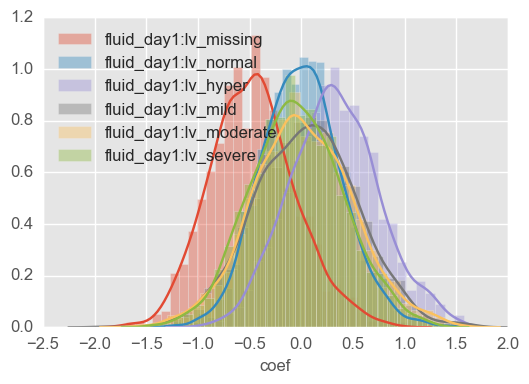

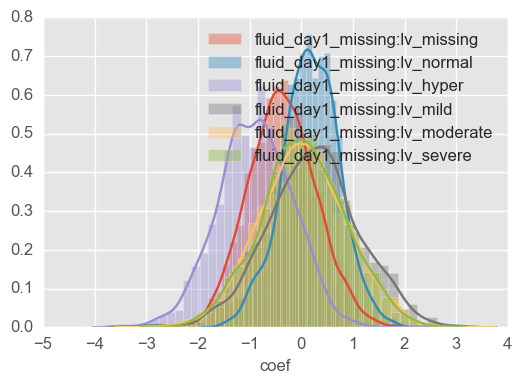

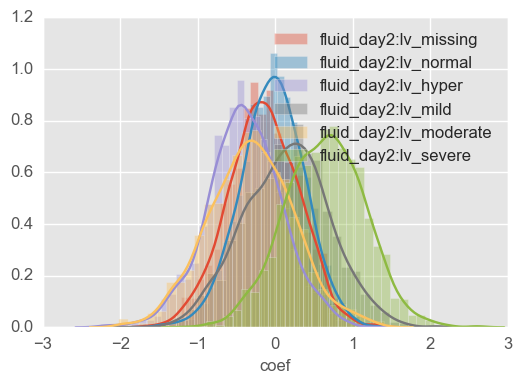

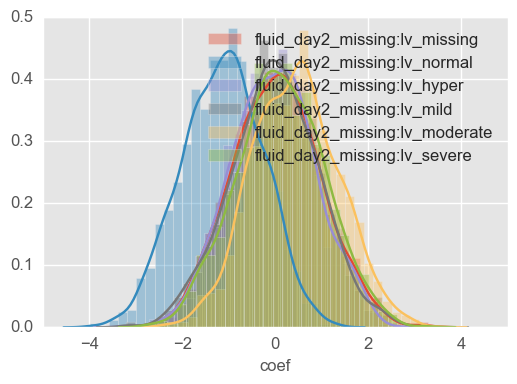

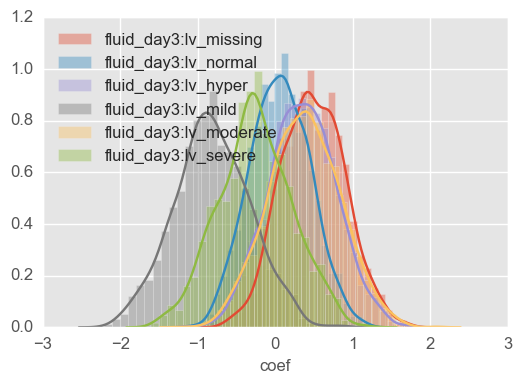

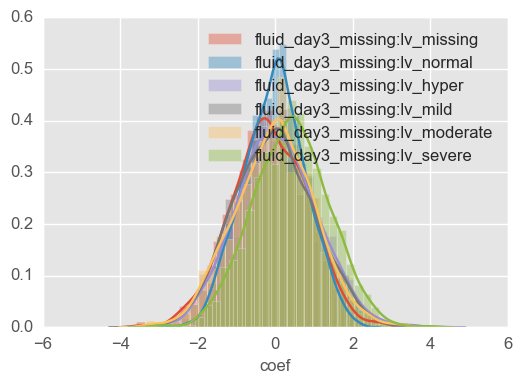

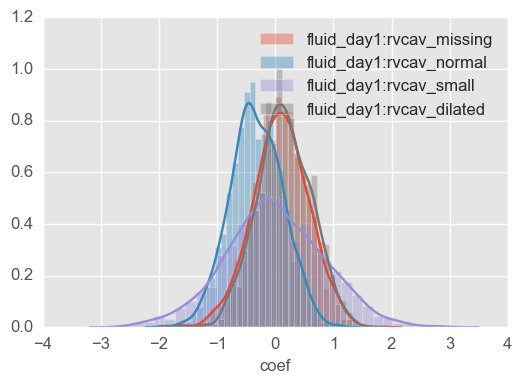

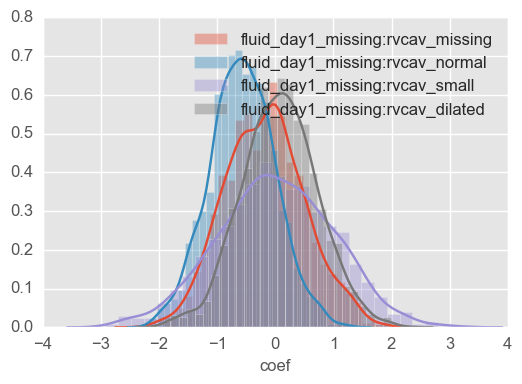

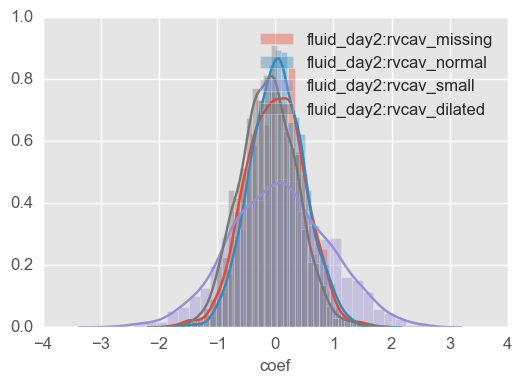

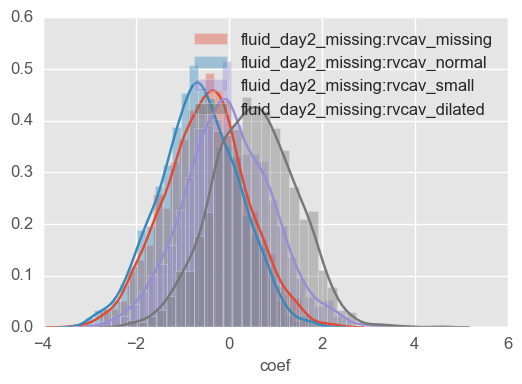

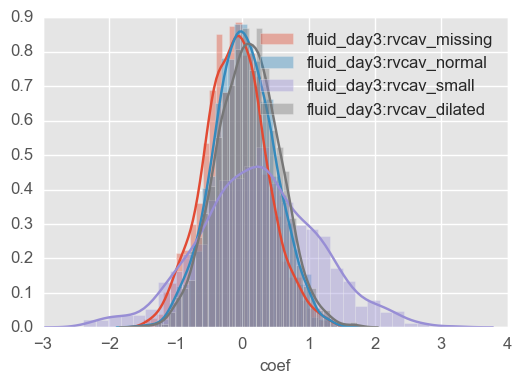

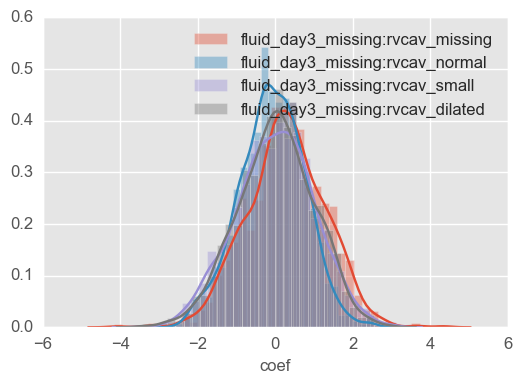

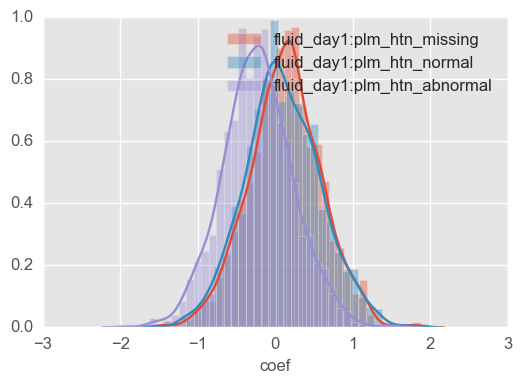

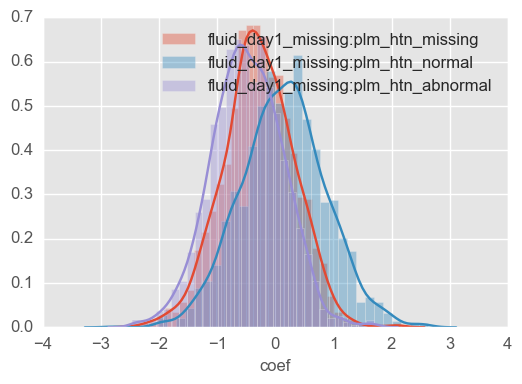

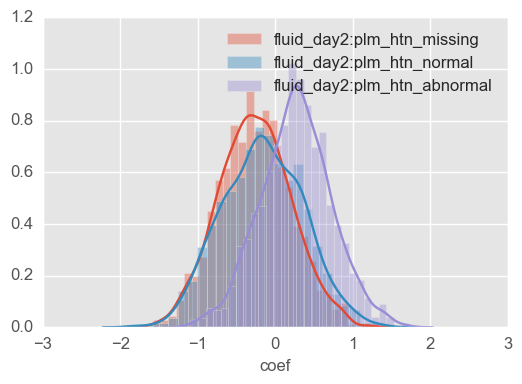

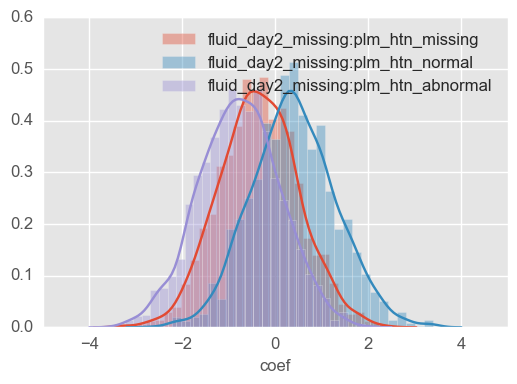

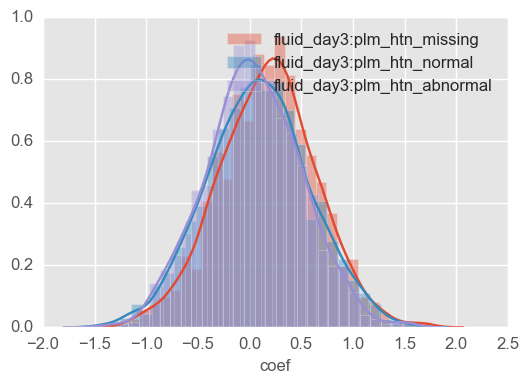

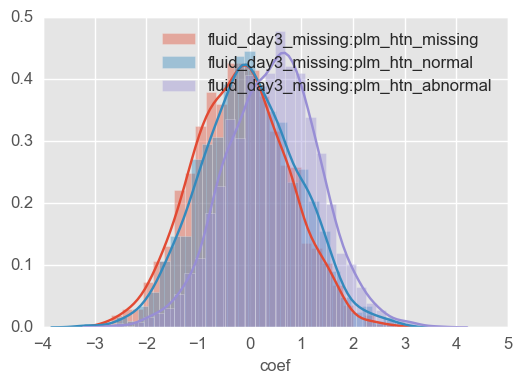

In [149]:
for et in ['lv_', 'rvcav', 'plm_htn']: 
    for fd in ['fluid_day1:', 'fluid_day1_missing', 'fluid_day2:', 'fluid_day2_missing', 'fluid_day3:', 'fluid_day3_missing']: 

        coefs = [c for c in sample_coefs.columns if (et in c) and (fd in c)]
        display(sample_coefs[coefs].describe())
        plt.figure()
        for coef in coefs:
            sns.distplot(sample_coefs[coef], label=coef)
        plt.xlabel('coef')
        _ = plt.legend(loc='best')